# Predicting Kickstarter Success

### Steps
1. Explore and clean data
2. Feature engineer "campaign_length"
3. Normalize data
4. Use these features in a Feed-Forward Neural Net first:
    - Goal (make sure to convert all non-US currencies to US) (number)
    - Category (dropdown → string)
    - Main category (dropdown → string)
    - Campaign length (in days)
- We are predicting "Pledged Amount"
5. Document score
6. Add in "name", tokenize and vectorize, pad_sequence up to MAXLEN
7. Run Neural Net, docuemnt score
8. Build LSTM, run and document score
9. Choose which model to train hyperparameters on
10. Make param_grid and set up GridSearchCV
11. Git push, tell Jonathan it's ready for training
12. Pickle and save model, help data engineering team

In [219]:
# Import libraries
import os
import re
import copy
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import Bidirectional, LSTM
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import Model

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.constraints import MaxNorm

import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier
from xgboost import XGBRegressor


pd.set_option("display.max_columns", False)
nlp = spacy.load('en_core_web_md')

In [5]:
# # Import dataset
# data_url = 'kickstarter_dataset.csv'
# df = pd.read_csv(
#     data_url, 
#     encoding_errors="ignore",
#     low_memory=False
# )
# # df = df.drop(columns=["backers","country","usd pledged",
# #                       "Unnamed: 13","Unnamed: 14","Unnamed: 15",
# #                      "Unnamed: 16"])

# df = df.iloc[:,:-5]

In [72]:
# Import dataset
data_url_2 = 'kickstarter_data_with_features.csv'
df = pd.read_csv(data_url_2)

df = df[(df['state'] != 'live') & (df['state'] != 'suspended')]

df.head()

/var/folders/qz/6bx8ghvn4634r7_lvlhmtdw80000gp/T/ipykernel_32309/2412827910.py:3: DtypeWarning: Columns (29,30,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url_2)


,Unnamed: 0,id,photo,name,blurb,goal,pledged,state,slug,disable_communication,country,currency,currency_symbol,currency_trailing_code,deadline,state_changed_at,created_at,launched_at,staff_pick,backers_count,static_usd_rate,usd_pledged,creator,location,category,profile,spotlight,urls,source_url,friends,is_starred,is_backing,permissions,name_len,name_len_clean,blurb_len,blurb_len_clean,deadline_weekday,state_changed_at_weekday,created_at_weekday,launched_at_weekday,deadline_month,deadline_day,deadline_yr,deadline_hr,state_changed_at_month,state_changed_at_day,state_changed_at_yr,state_changed_at_hr,created_at_month,created_at_day,created_at_yr,created_at_hr,launched_at_month,launched_at_day,launched_at_yr,launched_at_hr,create_to_launch,launch_to_deadline,launch_to_state_change
0,0,1454391034,"{""small"":""https://ksr-ugc.imgix.net/assets/011...",Auntie Di's Music Time Sign ASL for Hearing an...,MTS ASL Curriculum Workbook is a reproducible ...,1500.0,0.0,failed,auntie-dis-music-time-sign-asl-for-hearing-and...,False,US,USD,$,True,2015-01-23 10:35:00,2015-01-23 10:35:00,2014-11-29 22:55:57,2014-12-17 13:47:36,False,0,1.000000,0.000000,"{""urls"":{""web"":{""user"":""https://www.kickstarte...","{""country"":""US"",""urls"":{""web"":{""discover"":""htt...",Academic,"{""background_image_opacity"":0.8,""should_show_f...",False,"{""web"":{""project"":""https://www.kickstarter.com...",https://www.kickstarter.com/discover/categorie...,NaN,NaN,NaN,NaN,11.0,9.0,21.0,16.0,Friday,Friday,Saturday,Wednesday,1,23,2015,10,1,23,2015,10,11,29,2014,22,12,17,2014,13,17 days 14:51:39.000000000,36 days 20:47:24.000000000,NaN
1,1,1655206086,"{""small"":""https://ksr-ugc.imgix.net/assets/012...",Jump Start Kindergarten Toolkit,"This kit teaches how to print, correct an ugly...",500.0,0.0,failed,jump-start-kindergarten-toolkit,False,US,USD,$,True,2015-05-01 16:13:22,2015-05-01 16:13:24,2015-02-20 09:28:43,2015-03-02 16:13:22,False,0,1.000000,0.000000,"{""urls"":{""web"":{""user"":""https://www.kickstarte...","{""country"":""US"",""urls"":{""web"":{""discover"":""htt...",Academic,"{""background_image_opacity"":0.8,""should_show_f...",False,"{""web"":{""project"":""https://www.kickstarter.com...",https://www.kickstarter.com/discover/categorie...,NaN,NaN,NaN,NaN,4.0,4.0,23.0,15.0,Friday,Friday,Friday,Monday,5,1,2015,16,5,1,2015,16,2,20,2015,9,3,2,2015,16,10 days 06:44:39.000000000,60 days 00:00:00.000000000,NaN
2,2,311581827,"{""small"":""https://ksr-ugc.imgix.net/assets/012...",Ojukwu Balewa Awolowo (O.B.A.) Public Library ...,"Establishing a free, world-class, public libra...",100000.0,120.0,failed,ojukwu-balewa-awolowo-oba-public-library-of-ni...,False,US,USD,$,True,2015-03-26 08:17:04,2015-03-26 08:17:05,2015-01-24 00:08:06,2015-01-25 08:17:04,False,5,1.000000,120.000000,"{""urls"":{""web"":{""user"":""https://www.kickstarte...","{""country"":""NG"",""urls"":{""web"":{""discover"":""htt...",Academic,"{""background_image_opacity"":0.8,""should_show_f...",False,"{""web"":{""project"":""https://www.kickstarter.com...",https://www.kickstarter.com/discover/categorie...,NaN,NaN,NaN,NaN,8.0,8.0,18.0,10.0,Thursday,Thursday,Saturday,Sunday,3,26,2015,8,3,26,2015,8,1,24,2015,0,1,25,2015,8,1 days 08:08:58.000000000,60 days 00:00:00.000000000,NaN
3,3,859724515,"{""small"":""https://ksr-ugc.imgix.net/assets/011...","MASTIZE - [mas-TAHYZ, MAS-tahyz] - to spread",Goal: Introducing a new word into the English ...,5000.0,0.0,failed,mastize-mas-tahyz-mas-tahyz-to-spread,False,US,USD,$,True,2014-10-06 00:41:17,2014-10-06 00:41:17,2014-09-05 22:30:00,2014-09-06 00:41:17,False,0,1.000000,0.000000,"{""urls"":{""web"":{""user"":""https://www.kickstarte...","{""country"":""US"",""urls"":{""web"":{""discover"":""htt...",Academic,"{""background_image_opacity"":0.8,""should_show_f...",False,"{""web"":{""project"":""https://www.kickstarter.com...",https://www.kickstarter.com/discover/categorie...,NaN,NaN,NaN,NaN,7.0,6.0,21.0,13.0,Monday,Monday,Friday,Saturday,10,6,2014,0,10,6,20

In [102]:
df_2 = df[['name','blurb','goal','category','name_len','blurb_len',
       'deadline_weekday','launched_at_weekday','deadline_month',
       'launched_at_month','launch_to_deadline','state','usd_pledged']]

df_2.head()

,name,blurb,goal,category,name_len,blurb_len,deadline_weekday,launched_at_weekday,deadline_month,launched_at_month,launch_to_deadline,state,usd_pledged
0,Auntie Di's Music Time Sign ASL for Hearing an...,MTS ASL Curriculum Workbook is a reproducible ...,1500.0,Academic,11.0,21.0,Friday,Wednesday,1,12,36 days 20:47:24.000000000,failed,0.000000
1,Jump Start Kindergarten Toolkit,"This kit teaches how to print, correct an ugly...",500.0,Academic,4.0,23.0,Friday,Monday,5,3,60 days 00:00:00.000000000,failed,0.000000
2,Ojukwu Balewa Awolowo (O.B.A.) Public Library ...,"Establishing a free, world-class, public libra...",100000.0,Academic,8.0,18.0,Thursday,Sunday,3,1,60 days 00:00:00.000000000,failed,120.000000
3,"MASTIZE - [mas-TAHYZ, MAS-tahyz] - to spread",Goal: Introducing a new word into the English ...,5000.0,Academic,7.0,21.0,Monday,Saturday,10,9,30 days 00:00:00.000000000,failed,0.000000
4,"Synopse der EU-DSGVO - Artikel, Erwägungsgründ...",Zu den Artikeln der DSGVO sind die korrespondi...,3222.0,Academic,7.0,18.0,Monday,Thursday,6,5,32 days 06:02:33.000000000,failed,396.802395


In [106]:
df_2 = df_2.dropna()

In [107]:
df_2.isnull().sum()

name                   0
blurb                  0
goal                   0
category               0
name_len               0
blurb_len              0
deadline_weekday       0
launched_at_weekday    0
deadline_month         0
launched_at_month      0
launch_to_deadline     0
state                  0
usd_pledged            0
dtype: int64

In [108]:
df_2.shape

(18066, 13)

In [109]:
df_2.shape

(18066, 13)

In [110]:
# Two targets, one for regression and one for classification
y_reg = df_2[['usd_pledged']]
y_class = df_2[['state']]

# Create X dataframe
X = df_2[['name','blurb','goal','category','name_len','blurb_len',
       'deadline_weekday','launched_at_weekday','deadline_month',
       'launched_at_month','launch_to_deadline']]

In [111]:
X.head()

,name,blurb,goal,category,name_len,blurb_len,deadline_weekday,launched_at_weekday,deadline_month,launched_at_month,launch_to_deadline
0,Auntie Di's Music Time Sign ASL for Hearing an...,MTS ASL Curriculum Workbook is a reproducible ...,1500.0,Academic,11.0,21.0,Friday,Wednesday,1,12,36 days 20:47:24.000000000
1,Jump Start Kindergarten Toolkit,"This kit teaches how to print, correct an ugly...",500.0,Academic,4.0,23.0,Friday,Monday,5,3,60 days 00:00:00.000000000
2,Ojukwu Balewa Awolowo (O.B.A.) Public Library ...,"Establishing a free, world-class, public libra...",100000.0,Academic,8.0,18.0,Thursday,Sunday,3,1,60 days 00:00:00.000000000
3,"MASTIZE - [mas-TAHYZ, MAS-tahyz] - to spread",Goal: Introducing a new word into the English ...,5000.0,Academic,7.0,21.0,Monday,Saturday,10,9,30 days 00:00:00.000000000
4,"Synopse der EU-DSGVO - Artikel, Erwägungsgründ...",Zu den Artikeln der DSGVO sind die korrespondi...,3222.0,Academic,7.0,18.0,Monday,Thursday,6,5,32 days 06:02:33.000000000


In [112]:
len(X['name'])

18066

In [113]:
def tokenize(text):
    
    doc = nlp(text)
    tokens = []
    
    for token in doc:
        if (token.is_stop != True) & (token.is_punct != True) & \
        (token.lemma_.strip() != ""):
            tokens.append(token.lemma_.lower())
    
    
    return tokens

In [114]:
%%time
tokenize(X['name'][0])

CPU times: user 25.1 ms, sys: 91 ms, total: 116 ms
Wall time: 304 ms


['auntie', 'di', 'music', 'time', 'sign', 'asl', 'hearing', 'hoh', 'children']

In [12]:
%%time
# X['name_tokenized'] = X['name'].apply(tokenize)

CPU times: user 3min 4s, sys: 5.16 s, total: 3min 10s
Wall time: 4min 30s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [14]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20632 entries, 0 to 20631
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   name                 20632 non-null  object 
 1   blurb                20627 non-null  object 
 2   goal                 20632 non-null  float64
 3   category             18743 non-null  object 
 4   name_len             20627 non-null  float64
 5   blurb_len            20627 non-null  float64
 6   deadline_weekday     20632 non-null  object 
 7   launched_at_weekday  20632 non-null  object 
 8   deadline_month       20632 non-null  int64  
 9   launched_at_month    20632 non-null  int64  
 10  launch_to_deadline   20632 non-null  object 
 11  name_tokenized       20632 non-null  object 
dtypes: float64(3), int64(2), object(7)
memory usage: 1.9+ MB


In [81]:
%%time
# Create null function for TfidfVectorizer
def null_tokenizer(text):
    return text

tfidf_vect = TfidfVectorizer(
    stop_words="english",
    max_features=1000,
    lowercase=False,
    tokenizer=null_tokenizer
)

# tfidf_vect.fit(X['name_tokenized'])


CPU times: user 30 µs, sys: 23 µs, total: 53 µs
Wall time: 56.7 µs


In [17]:
dtm = tfidf_vect.transform(X['name_tokenized'])

dtm = dtm.toarray()
dtm = pd.DataFrame(data=dtm, columns=tfidf_vect.get_feature_names_out())
dtm

,$,+,1,10,100,1st,2,2.0,2013,2014,2015,2016,2017,21st,3,30,360,3d,4,5,6,7,8,9,=,academy,access,accessible,accessory,act,action,active,activity,ad,adapter,add,adjustable,advanced,adventure,aerial,...,wave,way,wear,wearable,weather,web,website,west,wheel,wheelchair,white,wi,wifi,wind,window,windows,wing,wire,wireless,woman,women,word,wordpress,work,workshop,world,worlds,worldwide,write,x,year,york,young,youth,zero,|,~,®,°,™
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20627,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20628,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20629,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20630,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [115]:
X['blurb'] = X['blurb'].astype(str)

/var/folders/qz/6bx8ghvn4634r7_lvlhmtdw80000gp/T/ipykernel_32309/1175555289.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['blurb'] = X['blurb'].astype(str)


In [27]:
%%time
# X['blurb_tokenized'] = X['blurb'].apply(tokenize)

CPU times: user 4min 26s, sys: 12.3 s, total: 4min 38s
Wall time: 10min 39s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [83]:
X.head()

,name,blurb,goal,category,name_len,blurb_len,deadline_weekday,launched_at_weekday,deadline_month,launched_at_month,launch_to_deadline
0,Auntie Di's Music Time Sign ASL for Hearing an...,MTS ASL Curriculum Workbook is a reproducible ...,1500.0,Academic,11.0,21.0,Friday,Wednesday,1,12,36 days 20:47:24.000000000
1,Jump Start Kindergarten Toolkit,"This kit teaches how to print, correct an ugly...",500.0,Academic,4.0,23.0,Friday,Monday,5,3,60 days 00:00:00.000000000
2,Ojukwu Balewa Awolowo (O.B.A.) Public Library ...,"Establishing a free, world-class, public libra...",100000.0,Academic,8.0,18.0,Thursday,Sunday,3,1,60 days 00:00:00.000000000
3,"MASTIZE - [mas-TAHYZ, MAS-tahyz] - to spread",Goal: Introducing a new word into the English ...,5000.0,Academic,7.0,21.0,Monday,Saturday,10,9,30 days 00:00:00.000000000
4,"Synopse der EU-DSGVO - Artikel, Erwägungsgründ...",Zu den Artikeln der DSGVO sind die korrespondi...,3222.0,Academic,7.0,18.0,Monday,Thursday,6,5,32 days 06:02:33.000000000


In [116]:
X_lem = copy.deepcopy(X)

In [117]:
# Function to OneHotEncode categorical data
def encode_and_concat(og_df, feature):
    dummies = pd.get_dummies(og_df[feature])
    for col in dummies.columns:
        dummies = dummies.rename(columns={col:feature + "_" + col.lower()})
    res = pd.concat([og_df, dummies], axis=1)
    res = res.drop(columns=[feature])
    return res

# OneHotEncode our categorical data
X_lem = encode_and_concat(X_lem, 'category')
X_lem = encode_and_concat(X_lem, 'deadline_weekday')
X_lem = encode_and_concat(X_lem, 'launched_at_weekday')
X_lem.head()

In [119]:
# Drop name and blurb columns
X_lem = X_lem.drop(columns=['name','blurb'])
X_lem.head()

,goal,name_len,blurb_len,deadline_month,launched_at_month,launch_to_deadline,category_academic,category_apps,category_blues,category_comedy,category_experimental,category_festivals,category_flight,category_gadgets,category_hardware,category_immersive,category_makerspaces,category_musical,category_places,category_plays,category_restaurants,category_robots,category_shorts,category_software,category_sound,category_spaces,category_thrillers,category_wearables,category_web,category_webseries,deadline_weekday_friday,deadline_weekday_monday,deadline_weekday_saturday,deadline_weekday_sunday,deadline_weekday_thursday,deadline_weekday_tuesday,deadline_weekday_wednesday,launched_at_weekday_friday,launched_at_weekday_monday,launched_at_weekday_saturday,launched_at_weekday_sunday,launched_at_weekday_thursday,launched_at_weekday_tuesday,launched_at_weekday_wednesday
0,1500.0,11.0,21.0,1,12,36 days 20:47:24.000000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,500.0,4.0,23.0,5,3,60 days 00:00:00.000000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
2,100000.0,8.0,18.0,3,1,60 days 00:00:00.000000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
3,5000.0,7.0,21.0,10,9,30 days 00:00:00.000000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
4,3222.0,7.0,18.0,6,5,32 days 06:02:33.000000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [120]:
# Get launch_to_deadline day count
def get_day_count(text):
    
    text = text.split("days")
    text = text[0]
    
    return text

X_lem['campaign_length_days'] = X_lem['launch_to_deadline'].apply(get_day_count)

In [121]:
X_lem.head()

,goal,name_len,blurb_len,deadline_month,launched_at_month,launch_to_deadline,category_academic,category_apps,category_blues,category_comedy,category_experimental,category_festivals,category_flight,category_gadgets,category_hardware,category_immersive,category_makerspaces,category_musical,category_places,category_plays,category_restaurants,category_robots,category_shorts,category_software,category_sound,category_spaces,category_thrillers,category_wearables,category_web,category_webseries,deadline_weekday_friday,deadline_weekday_monday,deadline_weekday_saturday,deadline_weekday_sunday,deadline_weekday_thursday,deadline_weekday_tuesday,deadline_weekday_wednesday,launched_at_weekday_friday,launched_at_weekday_monday,launched_at_weekday_saturday,launched_at_weekday_sunday,launched_at_weekday_thursday,launched_at_weekday_tuesday,launched_at_weekday_wednesday,campaign_length_days
0,1500.0,11.0,21.0,1,12,36 days 20:47:24.000000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,36
1,500.0,4.0,23.0,5,3,60 days 00:00:00.000000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,60
2,100000.0,8.0,18.0,3,1,60 days 00:00:00.000000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,60
3,5000.0,7.0,21.0,10,9,30 days 00:00:00.000000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,30
4,3222.0,7.0,18.0,6,5,32 days 06:02:33.000000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,32


In [122]:
X_lem = X_lem.drop(columns=['launch_to_deadline'])
X_lem.head()

,goal,name_len,blurb_len,deadline_month,launched_at_month,category_academic,category_apps,category_blues,category_comedy,category_experimental,category_festivals,category_flight,category_gadgets,category_hardware,category_immersive,category_makerspaces,category_musical,category_places,category_plays,category_restaurants,category_robots,category_shorts,category_software,category_sound,category_spaces,category_thrillers,category_wearables,category_web,category_webseries,deadline_weekday_friday,deadline_weekday_monday,deadline_weekday_saturday,deadline_weekday_sunday,deadline_weekday_thursday,deadline_weekday_tuesday,deadline_weekday_wednesday,launched_at_weekday_friday,launched_at_weekday_monday,launched_at_weekday_saturday,launched_at_weekday_sunday,launched_at_weekday_thursday,launched_at_weekday_tuesday,launched_at_weekday_wednesday,campaign_length_days
0,1500.0,11.0,21.0,1,12,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,36
1,500.0,4.0,23.0,5,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,60
2,100000.0,8.0,18.0,3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,60
3,5000.0,7.0,21.0,10,9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,30
4,3222.0,7.0,18.0,6,5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,32


In [123]:
# Save dataframe with tokens
X_with_tokens = copy.deepcopy(X_lem)

In [124]:
# X_lem = X_lem.drop(columns=['name_tokenized','blurb_tokenized'])
X_lem.head()

,goal,name_len,blurb_len,deadline_month,launched_at_month,category_academic,category_apps,category_blues,category_comedy,category_experimental,category_festivals,category_flight,category_gadgets,category_hardware,category_immersive,category_makerspaces,category_musical,category_places,category_plays,category_restaurants,category_robots,category_shorts,category_software,category_sound,category_spaces,category_thrillers,category_wearables,category_web,category_webseries,deadline_weekday_friday,deadline_weekday_monday,deadline_weekday_saturday,deadline_weekday_sunday,deadline_weekday_thursday,deadline_weekday_tuesday,deadline_weekday_wednesday,launched_at_weekday_friday,launched_at_weekday_monday,launched_at_weekday_saturday,launched_at_weekday_sunday,launched_at_weekday_thursday,launched_at_weekday_tuesday,launched_at_weekday_wednesday,campaign_length_days
0,1500.0,11.0,21.0,1,12,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,36
1,500.0,4.0,23.0,5,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,60
2,100000.0,8.0,18.0,3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,60
3,5000.0,7.0,21.0,10,9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,30
4,3222.0,7.0,18.0,6,5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,32


In [141]:
for col in X_lem.columns:
    X_lem[col] = X_lem[col].astype(float)

In [142]:
# Create function to encode success/failures
def encode_success(text):
    
    if text == 'successful':
        return 1
    else:
        return 0

In [143]:
y_class.value_counts()

0    12846
1     5220
Name: success, dtype: int64

In [144]:
y_class['success'] = y_class['state'].apply(encode_success)
y_class = y_class['success']
print(y_class.value_counts())
y_class

KeyError: 'state'

In [145]:
print(y_class.shape)
print(X_lem.shape)

(18066,)
(18066, 44)


In [151]:
xgb_class = XGBClassifier(
    use_label_encoder=False
)

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X_lem, y_class)

In [153]:
print(X_train.shape)
print(X_test.shape)

(13549, 44)
(4517, 44)


In [154]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13549 entries, 13070 to 1909
Data columns (total 44 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   goal                           13549 non-null  float64
 1   name_len                       13549 non-null  float64
 2   blurb_len                      13549 non-null  float64
 3   deadline_month                 13549 non-null  float64
 4   launched_at_month              13549 non-null  float64
 5   category_academic              13549 non-null  float64
 6   category_apps                  13549 non-null  float64
 7   category_blues                 13549 non-null  float64
 8   category_comedy                13549 non-null  float64
 9   category_experimental          13549 non-null  float64
 10  category_festivals             13549 non-null  float64
 11  category_flight                13549 non-null  float64
 12  category_gadgets               13549 non-nu

In [155]:
xgb_class.fit(X_train, y_train)
xgb_class.score(X_test, y_test)

/Users/WonderWolff/.local/share/virtualenvs/Kickstarter_Success_Predictor-jaK0ryJK/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[00:29:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7504981182200575

In [158]:
dir(xgb_class)

['_Booster',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__sklearn_is_fitted__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_can_use_inplace_predict',
 '_check_feature_names',
 '_check_n_features',
 '_configure_fit',
 '_early_stopping_attr',
 '_estimator_type',
 '_get_iteration_range',
 '_get_param_names',
 '_get_tags',
 '_get_type',
 '_more_tags',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_set_evaluation_result',
 '_validate_data',
 'apply',
 'base_score',
 'best_iteration',
 'best_ntree_limit',
 'best_score',
 'booster',
 'classes_',
 'coef_',
 'colsample_bylevel',
 'colsample_bynode',
 'colsample_bytree',
 'enable_categorical',
 'evals_result',
 'fe

In [159]:
xgb_class.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)>

In [161]:
len(xgb_class.feature_importances_)

44

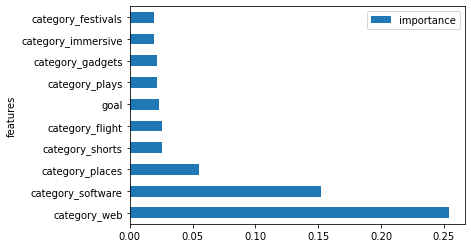

In [175]:
# Plot feature importances
feat_importances = pd.DataFrame(data=X_lem.columns, columns=['features'])
feat_importances['importance'] = xgb_class.feature_importances_
feat_importances.sort_values('importance', ascending=False, inplace=True)
top_10 = feat_importances.head(10)

top_10.plot(kind='barh', x='features', y='importance');

In [180]:
feat_importances

,features,importance
27,category_web,0.253819
22,category_software,0.152256
17,category_places,0.054920
21,category_shorts,0.025736
11,category_flight,0.025621
0,goal,0.023472
18,category_plays,0.021809
12,category_gadgets,0.021639
14,category_immersive,0.019631
10,category_festivals,0.019583


In [179]:
# Regression seems to predict horribly
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_lem, y_reg)
xgb_reg = XGBRegressor()
xgb_reg.fit(X_train_reg, y_train_reg)
xgb_reg.score(X_test_reg, y_test_reg)

/Users/WonderWolff/.local/share/virtualenvs/Kickstarter_Success_Predictor-jaK0ryJK/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


0.00042234199974400255

In [181]:
X_lem.columns

Index(['goal', 'name_len', 'blurb_len', 'deadline_month', 'launched_at_month',
       'category_academic', 'category_apps', 'category_blues',
       'category_comedy', 'category_experimental', 'category_festivals',
       'category_flight', 'category_gadgets', 'category_hardware',
       'category_immersive', 'category_makerspaces', 'category_musical',
       'category_places', 'category_plays', 'category_restaurants',
       'category_robots', 'category_shorts', 'category_software',
       'category_sound', 'category_spaces', 'category_thrillers',
       'category_wearables', 'category_web', 'category_webseries',
       'deadline_weekday_friday', 'deadline_weekday_monday',
       'deadline_weekday_saturday', 'deadline_weekday_sunday',
       'deadline_weekday_thursday', 'deadline_weekday_tuesday',
       'deadline_weekday_wednesday', 'launched_at_weekday_friday',
       'launched_at_weekday_monday', 'launched_at_weekday_saturday',
       'launched_at_weekday_sunday', 'launched_at_week

In [189]:
# Let's try this again, but not with any of the 
# "launched_at" or "deadline_" columns

basic_cols = []
for col in X_lem.columns:
    if "launched" not in col and "deadline" not in col:
        basic_cols.append(col)
    
X_basic = X_lem[basic_cols]
X_basic.head()

X_train_basic, X_test_basic, y_train_basic, y_test_basic = train_test_split(X_basic, y_class)

xgb_class_basic = XGBClassifier(
    use_label_encoder=False
)

xgb_class_basic.fit(X_train_basic, y_train_basic)
xgb_class_basic.score(X_test_basic, y_test_basic)

/Users/WonderWolff/.local/share/virtualenvs/Kickstarter_Success_Predictor-jaK0ryJK/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[00:54:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7666592871374807

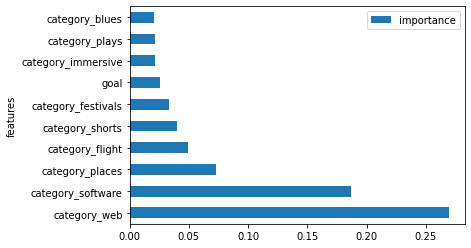

In [190]:
# Plot feature importances
feat_importances_basic = pd.DataFrame(data=X_basic.columns, columns=['features'])
feat_importances_basic['importance'] = xgb_class_basic.feature_importances_
feat_importances_basic.sort_values('importance', ascending=False, inplace=True)
top_10_basic = feat_importances_basic.head(10)

top_10_basic.plot(kind='barh', x='features', y='importance');

In [191]:
feat_importances_basic

,features,importance
25,category_web,0.269242
20,category_software,0.186585
15,category_places,0.073164
9,category_flight,0.049428
19,category_shorts,0.040010
8,category_festivals,0.032858
0,goal,0.025852
12,category_immersive,0.021713
16,category_plays,0.021551
5,category_blues,0.020907


In [217]:
xgb_class_basic.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)>

In [218]:
# Let's tune hyperparameters for XGBoost with X_basic

param_grid = {
    "max_depth" : [3, 6, 9],
    "learning_rate" : [0.3, 0.1, 0.01],
    "gamma" : [0, 0.25, 1],
    "n_estimators" : [50, 100, 150]
}

xgb_basic_tune = XGBClassifier(
    use_label_encoder=False
)

grid_cv = GridSearchCV(
    xgb_basic_tune,
    param_grid,
    n_jobs=-1,
    cv=3,
    verbose=1
)

grid_cv.fit(X_train_basic, y_train_basic)


Fitting 3 folds for each of 81 candidates, totalling 243 fits


/Users/WonderWolff/.local/share/virtualenvs/Kickstarter_Success_Predictor-jaK0ryJK/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/WonderWolff/.local/share/virtualenvs/Kickstarter_Success_Predictor-jaK0ryJK/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/WonderWolff/.local/share/virtualenvs/Kickstarter_Success_Predictor-jaK0ryJK/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/Won

/Users/WonderWolff/.local/share/virtualenvs/Kickstarter_Success_Predictor-jaK0ryJK/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/WonderWolff/.local/share/virtualenvs/Kickstarter_Success_Predictor-jaK0ryJK/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/WonderWolff/.local/share/virtualenvs/Kickstarter_Success_Predictor-jaK0ryJK/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstan

/Users/WonderWolff/.local/share/virtualenvs/Kickstarter_Success_Predictor-jaK0ryJK/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/WonderWolff/.local/share/virtualenvs/Kickstarter_Success_Predictor-jaK0ryJK/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/WonderWolff/.local/share/virtualenvs/Kickstarter_Success_Predictor-jaK0ryJK/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstan

/Users/WonderWolff/.local/share/virtualenvs/Kickstarter_Success_Predictor-jaK0ryJK/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/WonderWolff/.local/share/virtualenvs/Kickstarter_Success_Predictor-jaK0ryJK/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/WonderWolff/.local/share/virtualenvs/Kickstarter_Success_Predictor-jaK0ryJK/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstan

/Users/WonderWolff/.local/share/virtualenvs/Kickstarter_Success_Predictor-jaK0ryJK/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/WonderWolff/.local/share/virtualenvs/Kickstarter_Success_Predictor-jaK0ryJK/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/WonderWolff/.local/share/virtualenvs/Kickstarter_Success_Predictor-jaK0ryJK/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstan

/Users/WonderWolff/.local/share/virtualenvs/Kickstarter_Success_Predictor-jaK0ryJK/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/WonderWolff/.local/share/virtualenvs/Kickstarter_Success_Predictor-jaK0ryJK/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/WonderWolff/.local/share/virtualenvs/Kickstarter_Success_Predictor-jaK0ryJK/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstan

/Users/WonderWolff/.local/share/virtualenvs/Kickstarter_Success_Predictor-jaK0ryJK/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/WonderWolff/.local/share/virtualenvs/Kickstarter_Success_Predictor-jaK0ryJK/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/WonderWolff/.local/share/virtualenvs/Kickstarter_Success_Predictor-jaK0ryJK/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstan

/Users/WonderWolff/.local/share/virtualenvs/Kickstarter_Success_Predictor-jaK0ryJK/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/WonderWolff/.local/share/virtualenvs/Kickstarter_Success_Predictor-jaK0ryJK/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/WonderWolff/.local/share/virtualenvs/Kickstarter_Success_Predictor-jaK0ryJK/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstan

/Users/WonderWolff/.local/share/virtualenvs/Kickstarter_Success_Predictor-jaK0ryJK/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/WonderWolff/.local/share/virtualenvs/Kickstarter_Success_Predictor-jaK0ryJK/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/WonderWolff/.local/share/virtualenvs/Kickstarter_Success_Predictor-jaK0ryJK/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstan

/Users/WonderWolff/.local/share/virtualenvs/Kickstarter_Success_Predictor-jaK0ryJK/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/WonderWolff/.local/share/virtualenvs/Kickstarter_Success_Predictor-jaK0ryJK/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/WonderWolff/.local/share/virtualenvs/Kickstarter_Success_Predictor-jaK0ryJK/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstan

/Users/WonderWolff/.local/share/virtualenvs/Kickstarter_Success_Predictor-jaK0ryJK/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/WonderWolff/.local/share/virtualenvs/Kickstarter_Success_Predictor-jaK0ryJK/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/WonderWolff/.local/share/virtualenvs/Kickstarter_Success_Predictor-jaK0ryJK/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstan

[01:39:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


NameError: name 'grid_fit' is not defined

In [220]:
print(grid_cv.score(X_test_basic, y_test_basic))
print(grid_cv.best_score_)
print(grid_cv.best_params_)

0.7706442328979412
0.7603512930418882
{'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 50}
[01:28:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:28:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:28:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:28:54] WARNING: /Users/runner/work/

In [221]:
# Let's continue tuning

param_grid_2 = {
    "max_depth" : [2,3,4],
    "learning_rate" : [0.2, 0.3, 0.4],
    "n_estimators" : [25, 50, 75]
}

xgb_basic_tune_2 = XGBClassifier(
    use_label_encoder=False
)

grid_cv_2 = GridSearchCV(
    xgb_basic_tune_2,
    param_grid_2,
    n_jobs=-1,
    cv=3,
    verbose=3
)

grid_cv_2.fit(X_train_basic, y_train_basic)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


/Users/WonderWolff/.local/share/virtualenvs/Kickstarter_Success_Predictor-jaK0ryJK/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/WonderWolff/.local/share/virtualenvs/Kickstarter_Success_Predictor-jaK0ryJK/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/WonderWolff/.local/share/virtualenvs/Kickstarter_Success_Predictor-jaK0ryJK/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstan

/Users/WonderWolff/.local/share/virtualenvs/Kickstarter_Success_Predictor-jaK0ryJK/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/WonderWolff/.local/share/virtualenvs/Kickstarter_Success_Predictor-jaK0ryJK/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/WonderWolff/.local/share/virtualenvs/Kickstarter_Success_Predictor-jaK0ryJK/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstan

[01:28:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:28:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:28:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:28:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

/Users/WonderWolff/.local/share/virtualenvs/Kickstarter_Success_Predictor-jaK0ryJK/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/WonderWolff/.local/share/virtualenvs/Kickstarter_Success_Predictor-jaK0ryJK/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/WonderWolff/.local/share/virtualenvs/Kickstarter_Success_Predictor-jaK0ryJK/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstan

/Users/WonderWolff/.local/share/virtualenvs/Kickstarter_Success_Predictor-jaK0ryJK/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/WonderWolff/.local/share/virtualenvs/Kickstarter_Success_Predictor-jaK0ryJK/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/WonderWolff/.local/share/virtualenvs/Kickstarter_Success_Predictor-jaK0ryJK/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstan

[01:28:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:28:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:28:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:28:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

/Users/WonderWolff/.local/share/virtualenvs/Kickstarter_Success_Predictor-jaK0ryJK/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/WonderWolff/.local/share/virtualenvs/Kickstarter_Success_Predictor-jaK0ryJK/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/WonderWolff/.local/share/virtualenvs/Kickstarter_Success_Predictor-jaK0ryJK/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstan

[01:45:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight

In [222]:
print(grid_cv_2.score(X_test_basic, y_test_basic))
print(grid_cv_2.best_score_)
print(grid_cv_2.best_params_)

0.768873145893292
0.7604989326481678
{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 75}


In [224]:
dir(xgb_basic_tune_2)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__sklearn_is_fitted__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_can_use_inplace_predict',
 '_check_feature_names',
 '_check_n_features',
 '_configure_fit',
 '_early_stopping_attr',
 '_estimator_type',
 '_get_iteration_range',
 '_get_param_names',
 '_get_tags',
 '_get_type',
 '_more_tags',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_set_evaluation_result',
 '_validate_data',
 'apply',
 'base_score',
 'best_iteration',
 'best_ntree_limit',
 'best_score',
 'booster',
 'coef_',
 'colsample_bylevel',
 'colsample_bynode',
 'colsample_bytree',
 'enable_categorical',
 'evals_result',
 'feature_importances_',
 'fit

In [225]:
# Create final classifier

final_xgb = XGBClassifier(
    **grid_cv_2.best_params_
)

In [229]:
final_xgb.fit(X_train_basic, y_train_basic)

/Users/WonderWolff/.local/share/virtualenvs/Kickstarter_Success_Predictor-jaK0ryJK/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/WonderWolff/.local/share/virtualenvs/Kickstarter_Success_Predictor-jaK0ryJK/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:54:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=75, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [226]:
final_xgb.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_delta_step=None, max_depth=3,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=75, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None)>

In [242]:
X_test_basic[2:3]

,goal,name_len,blurb_len,category_academic,category_apps,category_blues,category_comedy,category_experimental,category_festivals,category_flight,category_gadgets,category_hardware,category_immersive,category_makerspaces,category_musical,category_places,category_plays,category_restaurants,category_robots,category_shorts,category_software,category_sound,category_spaces,category_thrillers,category_wearables,category_web,category_webseries,campaign_length_days
8944,16000.0,3.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,58.0


In [239]:
final_xgb.predict(X_test_basic.head(1))

/Users/WonderWolff/.local/share/virtualenvs/Kickstarter_Success_Predictor-jaK0ryJK/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


array([0])

In [195]:
print(X_train_basic.shape)
print(y_train_basic.shape)

(13549, 28)
(13549,)


## TODO
~~1. Pickle model~~
~~2. Save X_basic_train as csv for data engineering team~~
3. Write script for inputs that turn it into dataframe for prediction
4. Test loading pickled model and predicting on user's input

In [240]:
# Pickle model
xgb_file_name = 'xgb_class_1.pkl'

# save
pickle.dump(final_xgb, open(xgb_file_name, "wb"))

# load model to test
xgb_model_loaded = pickle.load(open('xgb_class_1.pkl', "rb"))

# test
xgb_model_loaded.predict(X_test_basic[2:3])

In [252]:
# Save X_basic_train as csv

X_basic_head = X_basic.head()

# Save
X_basic_head.to_csv('X_dataframe_example.csv', encoding='utf-8', index=False)

# Load and test dataframe -- 
# We need to transform the user's input into a 
# dataframe with these columns and dtypes
test_df = pd.read_csv('X_dataframe_example.csv')
display(test_df)
print(test_df.info())

,goal,name_len,blurb_len,category_academic,category_apps,category_blues,category_comedy,category_experimental,category_festivals,category_flight,category_gadgets,category_hardware,category_immersive,category_makerspaces,category_musical,category_places,category_plays,category_restaurants,category_robots,category_shorts,category_software,category_sound,category_spaces,category_thrillers,category_wearables,category_web,category_webseries,campaign_length_days
0,1500.0,11.0,21.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0
1,500.0,4.0,23.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0
2,100000.0,8.0,18.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0
3,5000.0,7.0,21.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0
4,3222.0,7.0,18.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   goal                   5 non-null      float64
 1   name_len               5 non-null      float64
 2   blurb_len              5 non-null      float64
 3   category_academic      5 non-null      float64
 4   category_apps          5 non-null      float64
 5   category_blues         5 non-null      float64
 6   category_comedy        5 non-null      float64
 7   category_experimental  5 non-null      float64
 8   category_festivals     5 non-null      float64
 9   category_flight        5 non-null      float64
 10  category_gadgets       5 non-null      float64
 11  category_hardware      5 non-null      float64
 12  category_immersive     5 non-null      float64
 13  category_makerspaces   5 non-null      float64
 14  category_musical       5 non-null      float64
 15  category_p

In [197]:
# Now let's test a simple feed forward neural network

model = Sequential()

model.add(Dense(128, input_dim=28, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])


In [199]:
model.fit(X_train_basic, y_train_basic,
         validation_data=(X_test_basic, y_test_basic),
            batch_size=32,
          epochs=10,
          verbose=1
         )

Epoch 1/10
424/424 [==============================] - 3s 8ms/step - loss: 24.0904 - accuracy: 0.6229 - val_loss: 38.9639 - val_accuracy: 0.7193
Epoch 2/10
424/424 [==============================] - 5s 12ms/step - loss: 206.7505 - accuracy: 0.6527 - val_loss: 9.9133 - val_accuracy: 0.6830
Epoch 3/10
424/424 [==============================] - 4s 10ms/step - loss: 288.7686 - accuracy: 0.6544 - val_loss: 375.6965 - val_accuracy: 0.7195
Epoch 4/10
424/424 [==============================] - 4s 9ms/step - loss: 75.3901 - accuracy: 0.6061 - val_loss: 355.4979 - val_accuracy: 0.7197
Epoch 5/10
424/424 [==============================] - 2s 4ms/step - loss: 182.2799 - accuracy: 0.6800 - val_loss: 3.8435 - val_accuracy: 0.5614
Epoch 6/10
424/424 [==============================] - 1s 3ms/step - loss: 31.6959 - accuracy: 0.5564 - val_loss: 462.0429 - val_accuracy: 0.7199
Epoch 7/10
424/424 [==============================] - 1s 3ms/step - loss: 163.6335 - accuracy: 0.6409 - val_loss: 582.6623 - val_a

In [202]:
X_train_basic.shape[0]

13549

In [216]:
X['category'].unique()

array(['Academic', 'Places', 'Blues', 'Restaurants', 'Webseries',
       'Thrillers', 'Shorts', 'Web', 'Apps', 'Gadgets', 'Hardware',
       'Festivals', 'Plays', 'Musical', 'Flight', 'Spaces', 'Immersive',
       'Experimental', 'Comedy', 'Wearables', 'Sound', 'Software',
       'Robots', 'Makerspaces'], dtype=object)

In [212]:
X_basic.columns

Index(['goal', 'name_len', 'blurb_len', 'category_academic', 'category_apps',
       'category_blues', 'category_comedy', 'category_experimental',
       'category_festivals', 'category_flight', 'category_gadgets',
       'category_hardware', 'category_immersive', 'category_makerspaces',
       'category_musical', 'category_places', 'category_plays',
       'category_restaurants', 'category_robots', 'category_shorts',
       'category_software', 'category_sound', 'category_spaces',
       'category_thrillers', 'category_wearables', 'category_web',
       'category_webseries', 'campaign_length_days'],
      dtype='object')

In [ ]:
# Tune our neural network



Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 128)         1734272   
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense_14 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1,865,985
Trainable params: 1,865,985
Non-trainable params: 0
_________________________________________________________________
